---
## Entrenamiento del modelo

Gran parte del codigo ejecutado en esta seccion se tomo de [Tutorial entrenamiento de Bert Fine Tuning](https://www.tensorflow.org/tfmodels/nlp/fine_tune_bert) el cual presenta el instructivo de entrenamiento de un modelo BERT, para este caso se ajustaron los datos y se configuraron parametros para el correcto funcionamiento del modelo


---

In [ ]:
#Connecting to the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Current path
%cd /content/drive/Shareddrives/PRUEBAS_BANCOLOMBIA_SMITH/Prueba practica
!pwd

/content/drive/Shareddrives/PRUEBAS_BANCOLOMBIA_SMITH/Prueba practica
/content/drive/Shareddrives/PRUEBAS_BANCOLOMBIA_SMITH/Prueba practica


In [ ]:
!ls

 dataset		 ds_format_beto.zip   files		      requeriments.txt
 diplomacy_format_beto	 dyplomacy_bert      'Prueba Practica.docx'


In [ ]:
#import jsonlines
import pandas as  pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#!unzip ./dataset/diplomacy_format_beto.zip

In [ ]:
# A dependency of the preprocessing for BERT inputs
!pip install -U "tensorflow-text==2.13.*" -q
!pip install "tf-models-official==2.13.*" -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 479.7/479.7 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 85.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 101.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 43.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.3/106.3 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.2/241.2 kB 21.2 MB/s eta 0:00:00


---
**Importing the required libraries**


---

In [ ]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

tf.get_logger().setLevel('ERROR')

---

### Carga de los datos

Luego de tener el paso de **1.Preprocesamiento.ipynb**  tendremos en la carpeta **diplomacy_format_beto** el dataset listo para ser inyectado en el entrenamiento de la forma:

```
train
  - True
  - False
test
  - True
  - False
validation
  - True
  - False
```

Donde True corresponde a los textos que son considerados verdaderos, y False los textos Falsos.

Para facilitar la carga de los datos usaremos la recomendacion del tutorial con el objeto 'text_dataset_from_directory' de esta forma se generan los tensores listos para cada una de las etapas.

---


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'diplomacy_format_beto/train',
    batch_size=batch_size,
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.utils.text_dataset_from_directory(
    'diplomacy_format_beto/validation',
    batch_size=batch_size,
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.utils.text_dataset_from_directory(
    'diplomacy_format_beto/test',
    batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


Found 10247 files belonging to 2 classes.
Found 1363 files belonging to 2 classes.
Found 2741 files belonging to 2 classes.


---
### Balanceo de las clases

Tanto en el paso de procesamiento como en el papper [ACL’20 paper (Peskov et al.).](https://users.umiacs.umd.edu/~jbg/docs/2020_acl_diplomacy.pdf) se puede ver que el dataset esta desbalanceado por lo tanto en las primeras pruebas del entrenamiento aunque la metrica del "val_binary_accuracy" era alta es debido a que todos los datos eran enviados por la clase verdadera, lo cual generaba un modelo con una metrica de accuracy alta pero incpaz de reconocer textos que eran mentira.

Por lo tanto fue necesario balancear las clases indicando a el entrenamiento que prestara mayor atencion a los datos de los textos que son mentira


---

In [ ]:
# Pesar las clases
neg_size = 570
ps_size = 11940

weight_for_0 = (1 / neg_size) * ( (neg_size + ps_size)/ 2.0)
weight_for_1 = (1 / ps_size) * ((neg_size + ps_size)/ 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}
class_weight

{0: 10.973684210526317, 1: 0.5238693467336684}

In [ ]:
# Veamos algunos de los textos
for text_batch, label_batch in test_ds.take(1):
  for i in range(10):
    print("Question: ", text_batch.numpy()[i])
    print("Label:", label_batch.numpy()[i])

Question:  b"I would love to work together with Austria, as I think it would be a very powerful alliance. But I fear I can't stop turkey and Austria from continuing to attack me. Also I'm a little worried about England \xf0\x9f\x98\xb0."
Label: 1
Question:  b'Sweet. That works fine as long as England follows through'
Label: 1
Question:  b"Ah yes, that it's unfortunate"
Label: 1
Question:  b'Hi Austria, what are your thoughts on Tyr? Any ideas for opening moves more generally?'
Label: 1
Question:  b'Sounds good'
Label: 1
Question:  b'But the board state is giving me a headache'
Label: 1
Question:  b'wow that did go well!'
Label: 1
Question:  b"Ok, that's totally sensible logic.  I may end up having to pass up on Greece and catch it next year.  I can support you into Trieste, if you'd rather have that than retaking Venice, sure."
Label: 1
Question:  b'Hey England how\xe2\x80\x99s it going?'
Label: 1
Question:  b'Sounds awesome.  Bud S Gal-Vie is coming from my end to help you out.'
Label

---

### Seleccion del modelo

Con el fin de dar velocidad a los entrenamientos de las diferentes pruebas se selecciona un modelo 'small_bert' junto con su modelo de preprocesamiento.


---

In [ ]:
#@title Choose a BERT model to fine-tune

bert_model_name = 'small_bert/bert_en_uncased_L-2_H-128_A-2'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [ ]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)



---


**Define  model**



---




In [ ]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text') # Capa de entrada
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing') # Capa Preprocesamiento
  encoder_inputs = preprocessing_layer(text_input) # Capa encoder
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder') # Capas del modelo preentrenado
  outputs = encoder(encoder_inputs) # Encoder final
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net) # Drop out para evitar sobreajuste
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net) # Capa final de seleccion de clases
  return tf.keras.Model(text_input, net)

classifier_model = build_classifier_model()

### Funcion de perdida

Usaremos una funcion de perdida binaria por ser un problema de clasificacion `losses.BinaryCrossentropy`.


In [ ]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

### Optimizador

Desde la documentacion se recomienda usar [AdamW](https://arxiv.org/abs/1711.05101) el cual sera el encargado de optimizar el entrenamiento para llegar a los mejores pesos, ademas se agrega tasa de aprendizaje dinamica, la cual se ajusta a medida que identifica el entrenamietno iniciando con un valor de 3e-5.

In [ ]:
epochs = 15
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [ ]:
# Compilacion del modelo
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

### Parada temprano y guardado del mejor modelo

Ademas de los parametros mostrados en el tutorial, agregamos parametro de parada rapida, encargada de identificar si la metrica de evalucion no cambia durante 4 epocas, el entrenamiento para sin tener que esperar a llegar a las 15 epocas.

Por otro lado el guardado del mejor modelo se encargara de guardar unicamente el mejor modelo como un checkpoint permitiendo que independiente de cual sea la metrica de la ultima epoca, se entregue el modelo de mejor metrica.

In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_binary_accuracy',
    patience = 4,
    restore_best_weights=True)

save_best = tf.keras.callbacks.ModelCheckpoint(
    './model_train/best_model_diplomacy.weights.h5 ',
    monitor="val_binary_accuracy",
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode="auto",
    save_freq="epoch",
    initial_value_threshold=None,
)

### Inicia el entrenamiento

Al dar inicio al entrenamiento se inyectan todos los parametros establecidos previamente, es de resaltar el parametro "class_weight" el cual permite tomar el balanceo de las clases que se incorporo al inicio

In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs,
                               class_weight =class_weight,
                               callbacks = [stop_early, save_best])

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1
Epoch 1/15
321/321 [==============================] - 1953s 6s/step - loss: 0.8065 - binary_accuracy: 0.3950 - val_loss: 0.3962 - val_binary_accuracy: 0.7843
Epoch 2/15
321/321 [==============================] - 153s 477ms/step - loss: 0.7860 - binary_accuracy: 0.4538 - val_loss: 0.3923 - val_binary_accuracy: 0.7586
Epoch 3/15
321/321 [==============================] - 162s 506ms/step - loss: 0.7606 - binary_accuracy: 0.4833 - val_loss: 0.3619 - val_binary_accuracy: 0.8026
Epoch 4/15
321/321 [==============================] - 156s 487ms/step - loss: 0.7521 - binary_accuracy: 0.5269 - val_loss: 0.3417 - val_binary_accuracy: 0.8540
Epoch 5/15
321/321 [==============================] - 154s 479ms/step - loss: 0.7217 - binary_accuracy: 0.5792 - val_loss: 0.4032 - val_binary_accuracy: 0.7256
Epoch 6/15
321/321 [==============================] - 155s 484ms/step - loss: 0.6869 - binary_accuracy: 0.5951

### Evaluacion del modelo

El entrenamiento del modedelo final tardo aproximandamente una hora parando en la epoca numero 8 debido al parado temprano pues desde la epoca 4 no se noto mejoria en la metrica de evaluacion.

Para evaluar el modelo y poder compara con los resultados de [ACL’20 paper (Peskov et al.).](https://users.umiacs.umd.edu/~jbg/docs/2020_acl_diplomacy.pdf) es necesario usar la metrica F1 score y prestar mayor atencion a la clase "False"

In [ ]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

86/86 [==============================] - 67s 786ms/step - loss: 0.3714 - binary_accuracy: 0.8431
Loss: 0.3714263141155243
Accuracy: 0.8431229591369629


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import f1_score

In [ ]:
y_true = np.concatenate([y.numpy() for _, y in test_ds])
ypredict1 = classifier_model.predict(test_ds)

86/86 [==============================] - 10s 114ms/step


In [ ]:
y_pred = (ypredict1 > 0.5).astype(int)

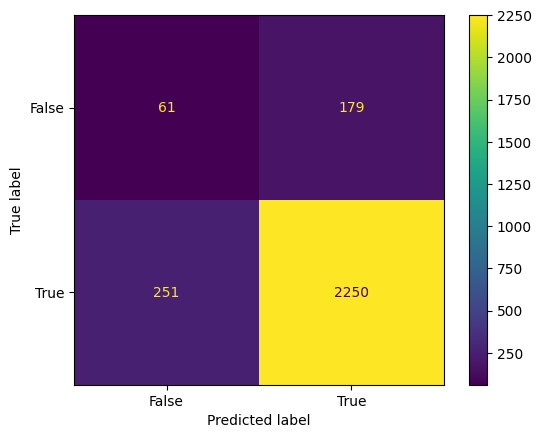

In [ ]:
con = confusion_matrix(y_true, y_pred )
ConfusionMatrixDisplay(con, display_labels=["False", 'True']).plot()

In [ ]:
f1_score_evaluation = f1_score(y_true, y_pred,average=None)
f1_score_macro = f1_score(y_true, y_pred,average='macro')

print('--'*40)
print("F1 score por clase = {}".format(f1_score_evaluation))
print('--'*40)
print("F1 Score Macro = {}".format(f1_score_macro))
print('--'*40)

--------------------------------------------------------------------------------
F1 score por clase = [0.22101449 0.9127789 ]
--------------------------------------------------------------------------------
F1 Score Macro = 0.5668966987094688
--------------------------------------------------------------------------------


In [ ]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.20      0.25      0.22       240
           1       0.93      0.90      0.91      2501

    accuracy                           0.84      2741
   macro avg       0.56      0.58      0.57      2741
weighted avg       0.86      0.84      0.85      2741



dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


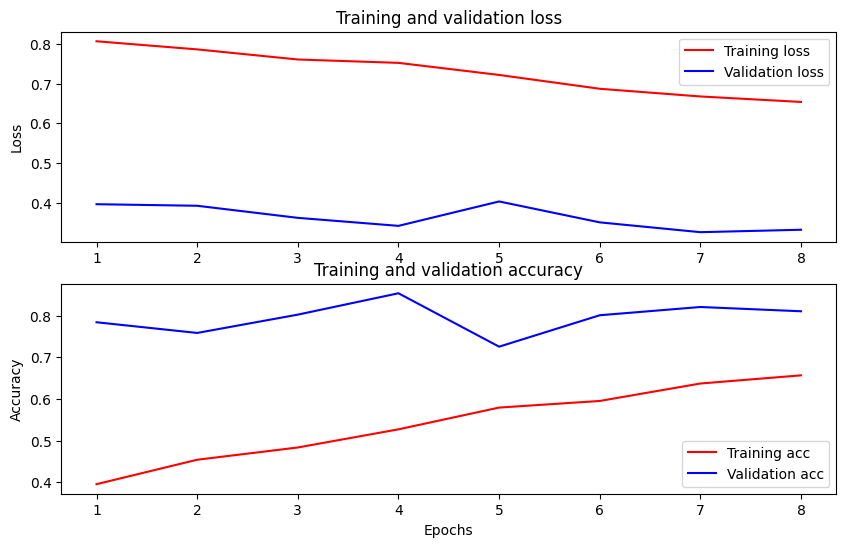

In [ ]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

## Conclusiones finales

Se puede ver que el valor del F1 score para los textos clasificados como mentira, es de 22 lo cual de forma general no es bueno, sin embargo, es aproximado a la linea base.

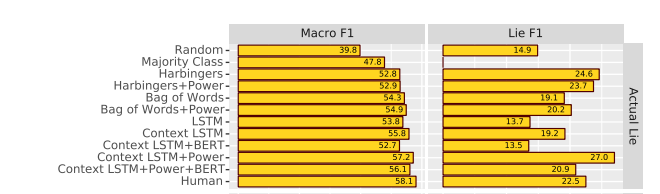

Como se puede ver para el lie F1 los mejores resultados son 27, 24.6, 23.7, y 22.5 por lo tanto el modelo se aproxima a los primeros 4 mejores resultados con un F1 Macro de 0.56.

Por otro lado desde la curva de aprendizaje de identifica que el entrenamiento podria mejorar con mas epocas, sin embargo, esto implicaria un mayor costo computacional

## Exportar el modelo

Exportamos el modelo para poderlo usar en futuras inferencias

In [ ]:
dataset_name = 'dyplomacy'
saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))

In [ ]:
from tensorflow import keras
new_model = keras.models.load_model(saved_model_path)
print(new_model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 preprocessing (KerasLayer)  {'input_mask': (None, 128)   0         ['text[0][0]']                
                             , 'input_type_ids': (None,                                           
                              128),                                                               
                              'input_word_ids': (None,                                            
                             128)}                                                                
                                                                                              

In [ ]:
classifier_model.save(saved_model_path, include_optimizer=False)

In [ ]:
reloaded_model = tf.saved_model.load(saved_model_path)

In [ ]:
def print_my_examples(inputs, results):
  result_for_printing = \
    [f'input: {inputs[i]:<30} : score: {results[i][0]:.6f}'
                         for i in range(len(inputs))]
  print(*result_for_printing, sep='\n')
  print()


examples = [
    'this is such an amazing movie!',  # this is the same sentence tried earlier
    'The movie was great!',
    'The movie was meh.',
    'The movie was okish.',
    'The movie was terrible...'
]

reloaded_results = tf.sigmoid(reloaded_model(tf.constant(examples)))
original_results = tf.sigmoid(classifier_model(tf.constant(examples)))

print('Results from the saved model:')
print_my_examples(examples, reloaded_results)
print('Results from the model in memory:')
print_my_examples(examples, original_results)

Results from the saved model:
input: this is such an amazing movie! : score: 0.874756
input: The movie was great!           : score: 0.895276
input: The movie was meh.             : score: 0.840765
input: The movie was okish.           : score: 0.869268
input: The movie was terrible...      : score: 0.797412

Results from the model in memory:
input: this is such an amazing movie! : score: 0.874756
input: The movie was great!           : score: 0.895276
input: The movie was meh.             : score: 0.840765
input: The movie was okish.           : score: 0.869268
input: The movie was terrible...      : score: 0.797412

